In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

,f0,f1,f2,f3,f4,f5,f6,choice
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.499270,0.498702,0.498533,0.501531,0.498766,0.500952,0.499686,0.999440
std,0.289282,0.288375,0.288627,0.289388,0.289506,0.288339,0.288819,0.815753
min,0.000015,0.000014,0.000003,0.000029,0.000070,0.000003,0.000021,0.000000
25%,0.248134,0.248480,0.246216,0.249915,0.246696,0.251421,0.249666,0.000000
50%,0.499140,0.497747,0.499030,0.502785,0.499129,0.501709,0.500490,1.000000
75%,0.751429,0.748098,0.747352,0.752928,0.750405,0.752237,0.747617,2.000000
max,0.999958,0.999994,0.999988,0.999984,0.999967,0.999983,0.999999,2.000000


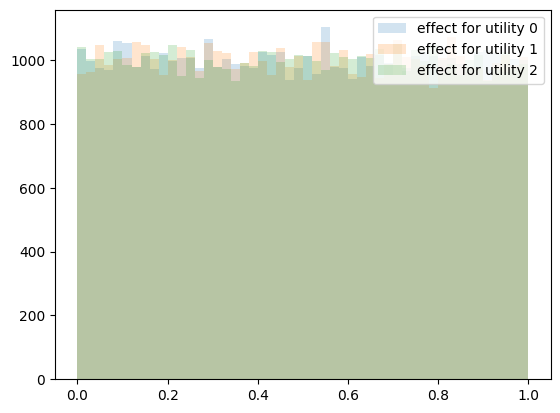

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from rumboost.metrics import mse, cross_entropy
np.random.seed(0)

def compute_levels(sp, betas):
    levels = np.zeros(len(sp))
    for i in range(len(sp) - 1):
        levels[i + 1] = levels[i] + (sp[i + 1] - sp[i]) * betas[i]
    return levels


def create_pw_linear_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    levels = compute_levels(sp, betas) + intercept
    f_x = levels[indices] + betas[indices] * (x - sp[indices])

    return f_x


def apply_linear_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_linear_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_pw_constant_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = betas[indices] + intercept

    return f_x

def apply_constant_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_constant_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data

def create_sinusoidal_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = np.sin(betas[indices] * x) + intercept
    return f_x

def apply_sinusoidal_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_sinusoidal_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_dataset(x_arr: np.ndarray, feature_names: list) -> pd.DataFrame:
    return pd.DataFrame({feature_names[i]: x_arr[:, i] for i in range(x_arr.shape[1])})


def generate_x(n, k, props_low=0.5, cut=0.5, deterministic=False, gaussian=False, semi_random=False):
    n_low = int(props_low * n)
    n_high = n - n_low
    if deterministic:
        x_low = np.linspace([0]*n_utility, [cut]*n_utility, n_low)
        x_high = np.linspace([cut]*n_utility, [1]*n_utility, n_high)
    elif gaussian:
        x_low = np.random.normal(loc=0, scale=cut, size=(n_low, k))
        x_high = np.random.normal(loc=cut, scale=1-cut, size=(n_high, k))
        x_low = np.clip(x_low, 0, cut)
        x_high = np.clip(x_high, cut, 1)
    elif semi_random:
        x_low = np.random.choice(np.linspace(0, cut-1, cut), (n_low, k))
        x_high = np.random.choice(np.linspace(cut-1, cut, cut), (n_high, k))
    else:
        x_low = np.random.uniform(0, cut, (n_low, k))
        x_high = np.random.uniform(cut, 1, (n_high, k))

    return np.concatenate([x_low, x_high], axis=0)

def nullify_features(x_arr: np.ndarray, feature_indices: list) -> np.ndarray:
    """
    Nullify the features in the dataset by setting them to zero.
    """
    x_arr[:, feature_indices] = np.zeros((x_arr.shape[0], len(feature_indices)))
    return x_arr

def create_simple_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> np.ndarray:
    """
    Create functional effects for a given number of utilities and features per utility.
    """
    effects = np.zeros((x.shape[0], n_utility))
    for i in range(n_utility):
        if i == 0:
            effects[:, i] = np.sum(x[:, :1], axis=1)
        elif i == 1:
            effects[:, i] = np.sum(x[:, 1:2], axis=1)
        elif i == 2:
            effects[:, i] = np.sum(x[:, 2:3], axis=1)
        else:
            effects[:, i] = np.median(x[:, :n_socio_dem], axis=1)

        # effects[:, i] = effects[:,i] / effects[:, i].max()
        # effects[:, i] = ((effects[:, i] - effects[:, i].mean())/effects[:, i].std())

        # effects[:, i] += np.random.normal(loc=0, scale=0.1, size=effects[:, i].shape)

    # effects = effects - effects[:, -1].reshape(-1, 1)
            
    return effects

def create_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> np.ndarray:
    """
    Create functional effects for a given number of utilities and features per utility.
    """
    effects = np.zeros((x.shape[0], n_utility))
    for i in range(n_utility):
        if i == 0:
            effects[:, i] = np.max(x[:, :n_socio_dem], axis=1) 
        elif i == 1:
            effects[:, i] = np.sum(x[:, :n_socio_dem], axis=1)
        elif i == 2:
            effects[:, i] = np.prod(x[:, :n_socio_dem], axis=1) 
        else:
            effects[:, i] = np.median(x[:, :n_socio_dem], axis=1)

        effects[:, i] = effects[:,i] / effects[:, i].max()
        # effects[:, i] = ((effects[:, i] - effects[:, i].mean())/effects[:, i].std())

        # effects[:, i] += np.random.normal(loc=0, scale=0.1, size=effects[:, i].shape)

    # effects = effects - effects[:, -1].reshape(-1, 1)
            
    return effects

def create_dumb_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> np.ndarray:
    """
    Create functional effects for a given number of utilities and features per utility.
    """
    effects = np.zeros((x.shape[0], n_utility))
    for i in range(n_utility):
        if i == 0:
            effects[:, i] = np.where(x[:, :n_socio_dem].sum(axis=1) < 2, 1, 0)
        elif i == 1:
            effects[:, i] = np.where(x[:, :n_socio_dem].sum(axis=1) < 2, 1, -1)
        elif i == 2:
            effects[:, i] = np.where(x[:, :n_socio_dem].sum(axis=1) < 2, 0.5, -0.5)
        else:
            effects[:, i] = np.where(x[:, :n_socio_dem].sum(axis=1) < 2, 2, 1)

        # effects[:, i] /= effects[:, i].max()

        # effects[:, i] += np.random.normal(loc=0, scale=0.1, size=effects[:, i].shape)

            
    return effects

def apply_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> pd.DataFrame:
    """
    Apply functional effects to the input data and return a DataFrame.
    """
    effects = create_simple_functional_effects(x, n_utility, n_socio_dem)
    # effects = create_functional_effects(x, n_utility, n_socio_dem)
    # effects = create_dumb_functional_effects(x, n_utility, n_socio_dem)
    feature_names = [f"f{i}" for i in range(n_utility)]
    
    return pd.DataFrame(effects, columns=feature_names)

def add_alt_spec_features(dataset_transformed: pd.DataFrame, x_alt: np.ndarray, n_utility: int, coeff: list, n_socio_dem: int) -> pd.DataFrame:
    """
    Add alternative specific features to the transformed dataset.
    """
    
    for i in range(n_utility):
        dataset_transformed.iloc[:, i] += coeff[i] * x_alt[:, i + n_socio_dem]
        # dataset_transformed.iloc[:, i] += coeff[i] * x_alt[:, n_socio_dem]
        # dataset_transformed.iloc[:, i] += np.sum(coeff * x_alt[:, n_socio_dem:], axis=1)

    
    return dataset_transformed

def add_choice(row, u_idx, regression=False):
    u = np.array([np.sum(row[u_idx[i][0] : u_idx[i][1]]) for i in range(len(u_idx))])
    # p = u-u.min()
    # p = p/(p.sum())
    p = softmax(u)
    if regression:
        return u[0]
    else:
        return np.random.choice(u.shape[0], size=1, p=p)[0]
        # return np.argmax(u) 

n_utility = 3
regression = n_utility == 1
f_per_utility = 5
n_alt_spec = 1
n_socio_dem = 4
tot_features = n_socio_dem + n_utility * n_alt_spec
x_arr = generate_x(50000, tot_features, 1, 1, gaussian=False, semi_random=False)
x_arr_test = generate_x(10000, tot_features, 1, 1, gaussian=False, semi_random=False)
# x_arr = nullify_features(x_arr, [i + n_socio_dem for i in range(n_utility)])
# x_arr_test = nullify_features(x_arr_test, [i + n_socio_dem for i in range(n_utility)])

coeff = [-1, -1, -1, -1]
# coeff = [0, 0, 0, 0]

feature_names = [f"f{i}" for i in range(tot_features)]

u_idx = [(i, (i+1)) for i in range(n_utility)]

y_plot = apply_functional_effects(x_arr, n_utility, n_socio_dem)
for i in range(n_utility):
    plt.hist(y_plot.iloc[:, i], label = f"effect for utility {i}", alpha = 0.2, bins=50)
    plt.legend()

dataset = create_dataset(x_arr, feature_names)
dataset_transf = apply_functional_effects(x_arr, n_utility, n_socio_dem)
dataset_transf = add_alt_spec_features(dataset_transf, x_arr, n_utility, coeff, n_socio_dem)
dataset["choice"] = dataset_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)
dataset_test = create_dataset(x_arr_test, feature_names)
dataset_test_transf = apply_functional_effects(x_arr_test, n_utility, n_socio_dem)
dataset_test_transf = add_alt_spec_features(dataset_test_transf, x_arr_test, n_utility, coeff, n_socio_dem)
dataset_test["choice"] = dataset_test_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)

dataset.describe()

In [39]:
dataset_transf

,f0,f1,f2
0,0.125159,0.069295,0.165176
1,0.362878,0.395618,-0.542155
2,-0.707121,-0.782883,-0.958400
3,0.159238,0.318126,-0.164140
4,0.065698,-0.153772,0.245766
...,...,...,...
49995,0.526900,-0.285451,0.268909
49996,-0.250627,-0.372676,0.138401
49997,0.921603,0.176666,0.314232
49998,-0.673016,-0.017790,-0.496498


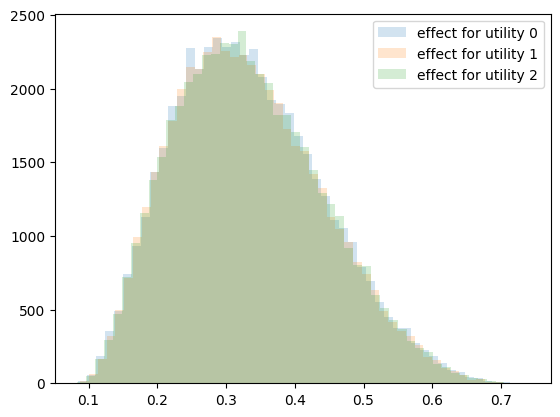

In [40]:
for i in range(n_utility):
    # plt.hist(np.argmax(dataset_transf, axis=1), label = f"effect for utility {i}", alpha = 0.2, bins=50)
    plt.hist((softmax(dataset_transf.values, axis=1)[:, i]), label = f"effect for utility {i}", alpha = 0.2, bins=50)
    plt.legend()

In [41]:
from models_wrapper import RUMBoost, TasteNet
from parser import parse_cmdline_args
from synthetic_experiment import gather_functional_intercepts, l1_distance

alt_spec_features = {i: [f"f{i+n_socio_dem}"] for i in range(n_utility)}
# alt_spec_features = {i: [f"f{n_socio_dem}"] for i in range(n_utility)}
# alt_spec_features = {i: [f"f4", "f5", "f6", "f7"] for i in range(n_utility)}
# alt_spec_features = {0: []}
socio_demo_chars = [f"f{i}" for i in range(n_socio_dem)]
X_train = dataset.drop(columns=["choice"])
X_val = dataset_test.drop(columns=["choice"])
y_train = dataset["choice"]
y_val = dataset_test["choice"]

In [42]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [58]:
model = "RUMBoost"
args = parse_cmdline_args()
args.functional_intercept = True
args.functional_params = False
args.feature_fraction = 1.0
args.save_model =False 
args.model = model
args.dataset = "synthetic"
args.learning_rate = 1
args.device = "cuda"
args.num_iterations = 1000
args.early_stopping_rounds = None 
args.num_leaves = 5
args.max_depth = -1

model = RUMBoost(
    alt_spec_features=alt_spec_features,
    socio_demo_chars=socio_demo_chars,
    num_classes=n_utility,
    args=args,
    )

# build dataloader
model.build_dataloader(X_train, y_train, X_val, y_val)

# fit model
best_train_loss, best_val_loss = model.fit()


# predict on the test set
preds, _, _ = model.predict(X_val)
if regression:
    loss_test = mse(preds, y_val)
else:
    loss_test = cross_entropy(preds, y_val)



/home/nicolas-salvade/panel-data/src/rumboost/rumboost.py:2680: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[1]------NCE value on train set : 1.0924
---------NCE value on test set 1: 1.0924
[11]-----NCE value on train set : 1.0610
---------NCE value on test set 1: 1.0603
[21]-----NCE value on train set : 1.0511
---------NCE value on test set 1: 1.0505
[31]-----NCE value on train set : 1.0471
---------NCE value on test set 1: 1.0465
[41]-----NCE value on train set : 1.0450
---------NCE value on test set 1: 1.0448
[51]-----NCE value on train set : 1.0437
---------NCE value on test set 1: 1.0440
[61]-----NCE value on train set : 1.0426
---------NCE value on test set 1: 1.0435
[71]-----NCE value on train set : 1.0418
---------NCE value on test set 1: 1.0432
[81]-----NCE value on train set : 1.0411
---------NCE value on test set 1: 1.0

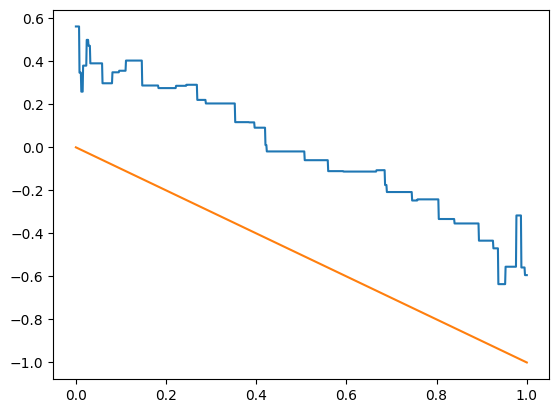

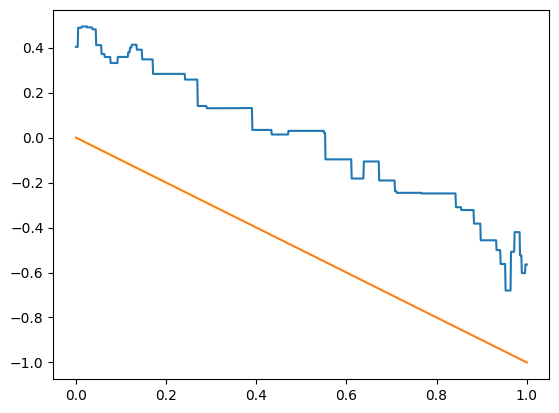

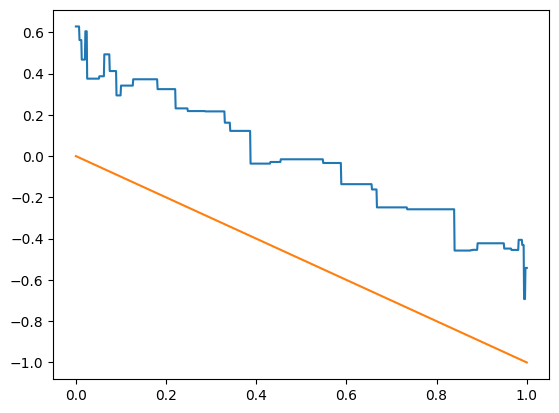

In [59]:
x_plot = np.linspace(0, 1, 1000).reshape(-1, 1)
y_alt = []
for i, booster in enumerate(model.model.boosters[:-n_utility]):
    plt.figure()
    y_plot = booster.predict(x_plot)
    y_a = booster.predict(dataset.iloc[:, i+n_socio_dem].values.reshape(-1,1))
    plt.plot(x_plot, y_plot, label="predicted utility")
    plt.plot(x_plot, coeff[i] *x_plot, label="true utility")
    y_alt.append(y_a)

In [60]:
model.rum_structure

[{'variables': ['f4'],
  'utility': [0],
  'boosting_params': {'monotone_constraints_method': 'advanced',
   'max_depth': 1,
   'n_jobs': -1,
   'learning_rate': np.float64(0.1),
   'verbose': -1,
   'monotone_constraints': [0],
   'interaction_constraints': [[0]],
   'num_leaves': 5,
   'min_gain_to_split': 0.0,
   'min_sum_hessian_in_leaf': 0.001,
   'max_bin': 255,
   'min_data_in_bin': 3,
   'min_data_in_leaf': 20,
   'feature_fraction': 1.0,
   'bagging_fraction': 1.0,
   'bagging_freq': 0,
   'lambda_l1': 0.0,
   'lambda_l2': 0.0},
  'shared': False},
 {'variables': ['f5'],
  'utility': [1],
  'boosting_params': {'monotone_constraints_method': 'advanced',
   'max_depth': 1,
   'n_jobs': -1,
   'learning_rate': np.float64(0.1),
   'verbose': -1,
   'monotone_constraints': [0],
   'interaction_constraints': [[0]],
   'num_leaves': 5,
   'min_gain_to_split': 0.0,
   'min_sum_hessian_in_leaf': 0.001,
   'max_bin': 255,
   'min_data_in_bin': 3,
   'min_data_in_leaf': 20,
   'feature_f

In [61]:
# get learnt functional intercepts
learnt_fct_intercepts = gather_functional_intercepts(
    dataset, model, socio_demo_chars, n_utility
)
learnt_fct_intercepts_test = gather_functional_intercepts(
    dataset_test, model, socio_demo_chars, n_utility
)

# compute L1 distance between true and learnt functional intercepts
l1_distance_train = l1_distance(
    dataset_transf,
    learnt_fct_intercepts,
)
l1_distance_test = l1_distance(
    dataset_test_transf,
    learnt_fct_intercepts_test,
)

print(f"Best Train Loss: {best_train_loss}, Best Val Loss: {best_val_loss}")
print(f"Test Loss: {loss_test}")

Best Train Loss: 1.0015586614608765, Best Val Loss: 1.0428968667984009
Test Loss: 1.0511308837658084


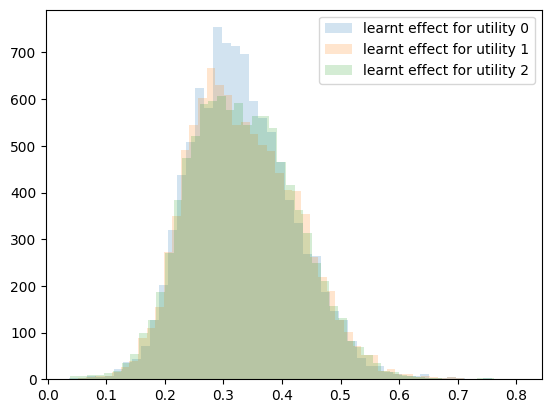

In [63]:
for i in range(n_utility):
    # plt.hist(learnt_fct_intercepts[:,i], label = f"learnt effect for utility {i}", alpha = 0.2, bins=50)
    plt.hist(softmax(learnt_fct_intercepts_test,axis=1)[:,i], label = f"learnt effect for utility {i}", alpha = 0.2, bins=50)
    plt.legend()

In [49]:
import lightgbm as lgb

train_set = lgb.Dataset(X_train[["f0", "f1", "f2", "f3"]], label=y_train)
val_set = lgb.Dataset(X_val[["f0", "f1", "f2", "f3"]], label=y_val)

params = {
          "objective": "multiclass" if not regression else "regression",
          "num_class": n_utility,
          "verbosity": 1,
          "num_leaves": 15,
          "learning_rate": 0.1,
          "metric": "multi_logloss" if not regression else "mse",
          "boosting_type": "gbdt",
        #   "lambda_l1": 0.1,
        #   "lambda_l2": 0.1,
          }
model = lgb.train(params, train_set, num_boost_round=1000)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 4
[LightGBM] [Info] Start training from score -1.099613
[LightGBM] [Info] Start training from score -1.094939
[LightGBM] [Info] Start training from score -1.101296


In [50]:
preds

array([[0.11910296, 0.44574815, 0.43514889],
       [0.47787047, 0.10488498, 0.41724454],
       [0.4060043 , 0.19434717, 0.39964854],
       ...,
       [0.29911051, 0.31749606, 0.38339343],
       [0.55510278, 0.29912776, 0.14576946],
       [0.18981749, 0.2541393 , 0.55604321]])

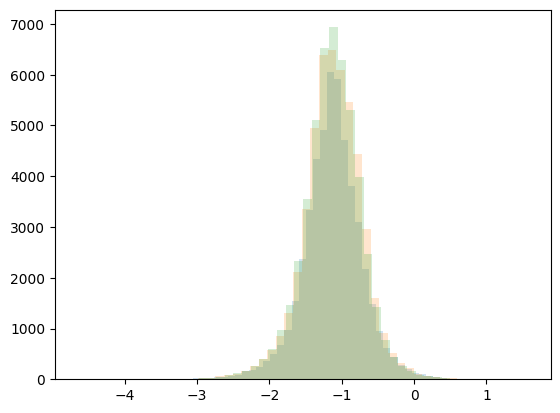

In [51]:
x_plot = dataset[["f0", "f1", "f2", "f3"]].copy()
preds = model.predict(x_plot, raw_score=True)

for i, p in enumerate(preds.T):
    plt.hist(p, bins=50, alpha=0.2, label=f"predicted effects for utility {i}")
    # plt.hist(softmax(preds, axis=1)[:,i], bins=50, alpha=0.2, label=f"predicted effects for utility {i}")

In [45]:
# get learnt functional intercepts
learnt_fct_intercepts = gather_functional_intercepts(
    dataset, model, socio_demo_chars, n_utility
)
learnt_fct_intercepts_test = gather_functional_intercepts(
    dataset_test, model, socio_demo_chars, n_utility
)

# compute L1 distance between true and learnt functional intercepts
l1_distance_train = l1_distance(
    dataset_transf,
    learnt_fct_intercepts,
)
l1_distance_test = l1_distance(
    dataset_test_transf,
    learnt_fct_intercepts_test,
)

print(f"Best Train Loss: {best_train_loss}, Best Val Loss: {best_val_loss}")
print(f"Test Loss: {loss_test}")

AttributeError: 'Booster' object has no attribute 'model'

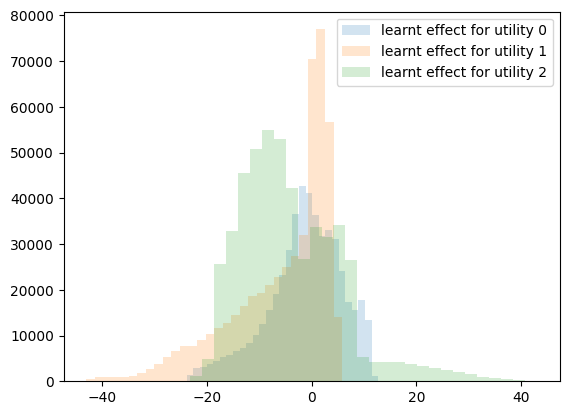

In [ ]:
for i in range(n_utility):
    plt.hist(learnt_fct_intercepts[:,i], label = f"learnt effect for utility {i}", alpha = 0.2, bins=30)
    plt.legend()
    # plt.hist(softmax(learnt_fct_intercepts_test,axis=1)[:,i], label = f"learnt effect for utility {i}", alpha = 0.2, bins=50)

In [ ]:
from models_wrapper import RUMBoost, TasteNet
from parser import parse_cmdline_args
from synthetic_experiment import gather_functional_intercepts, l1_distance

alt_spec_features = {i: [f"f{i+n_socio_dem}"] for i in range(n_utility)}
# alt_spec_features = {i: [f"f{n_socio_dem}"] for i in range(n_utility)}
# alt_spec_features = {i: [f"f4", "f5", "f6", "f7"] for i in range(n_utility)}
# alt_spec_features = {0: []}
socio_demo_chars = [f"f{i}" for i in range(n_socio_dem)]
X_train = dataset.drop(columns=["choice"])
X_val = dataset_test.drop(columns=["choice"])
y_train = dataset["choice"]
y_val = dataset_test["choice"]

In [8]:
model = "TasteNet"
args = parse_cmdline_args()
args.functional_intercept = True
args.functional_params = False
args.feature_fraction = 1.0
args.save_model = False 
args.model = model
args.dataset = "synthetic"
args.device = "cuda"


model = TasteNet(
    alt_spec_features=alt_spec_features,
    socio_demo_chars=socio_demo_chars,
    num_classes=n_utility,
    num_latent_vals=None,
    args=args,
)

y_train = y_train.astype(int)
y_val = y_val.astype(int)

# build dataloader
model.build_dataloader(X_train, y_train, X_val, y_val)

# fit model
best_train_loss, best_val_loss = model.fit()


# predict on the test set
preds, _, _ = model.predict(X_val)
loss_test = cross_entropy(preds, y_val)



c:\Users\ucesnjs\anaconda32\envs\old_rumboost\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


--- Batch 0/196, loss: 1.1852
--- Batch 50/196, loss: 1.0672
--- Batch 100/196, loss: 1.0665
--- Batch 150/196, loss: 1.0592
Epoch 1/200: train loss = 1.0700, val. loss: 1.0603
--- Batch 0/196, loss: 1.0772
--- Batch 50/196, loss: 1.0764
--- Batch 100/196, loss: 1.0337
--- Batch 150/196, loss: 1.0695
Epoch 2/200: train loss = 1.0615, val. loss: 1.0605
--- Batch 0/196, loss: 1.0333
--- Batch 50/196, loss: 1.0507
--- Batch 100/196, loss: 1.0356
--- Batch 150/196, loss: 1.0404
Epoch 3/200: train loss = 1.0599, val. loss: 1.0580
--- Batch 0/196, loss: 1.0672
--- Batch 50/196, loss: 1.0741
--- Batch 100/196, loss: 1.0735
--- Batch 150/196, loss: 1.0500
Epoch 4/200: train loss = 1.0589, val. loss: 1.0573
--- Batch 0/196, loss: 1.0670
--- Batch 50/196, loss: 1.0592
--- Batch 100/196, loss: 1.0821
--- Batch 150/196, loss: 1.0442
Epoch 5/200: train loss = 1.0579, val. loss: 1.0573
--- Batch 0/196, loss: 1.0767
--- Batch 50/196, loss: 1.0490
--- Batch 100/196, loss: 1.0681
--- Batch 150/196, los

In [9]:
# get learnt functional intercepts
learnt_fct_intercepts = gather_functional_intercepts(
    dataset, model, socio_demo_chars, n_utility
)
learnt_fct_intercepts_test = gather_functional_intercepts(
    dataset_test, model, socio_demo_chars, n_utility
)

# compute L1 distance between true and learnt functional intercepts
l1_distance_train = l1_distance(
    dataset_transf,
    learnt_fct_intercepts,
)
l1_distance_test = l1_distance(
    dataset_test_transf,
    learnt_fct_intercepts_test,
)

print(f"Best Train Loss: {best_train_loss}, Best Val Loss: {best_val_loss}")
print(f"Test Loss: {loss_test}")

Best Train Loss: 1.0554296623687356, Best Val Loss: 1.0557334214448928
Test Loss: 1.0565415620803833


c:\Users\ucesnjs\anaconda32\envs\old_rumboost\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


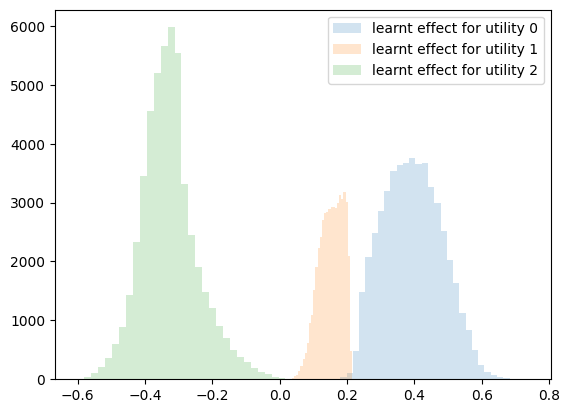

In [10]:
for i in range(n_utility):
    plt.hist(learnt_fct_intercepts[:,i], label = f"learnt effect for utility {i}", alpha = 0.2, bins=30)
    plt.legend()
    # plt.hist(softmax(learnt_fct_intercepts_test,axis=1)[:,i], label = f"learnt effect for utility {i}", alpha = 0.2, bins=50)